In [1]:
import cv2
import math
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt

# 1. Image reading

*==============* First lab *==============*
Src Image:  data/src_balls.jpg


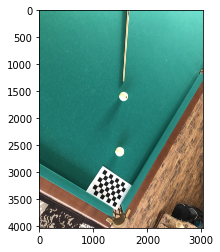

In [2]:
print("*==============* First lab *==============*")
path_to_img = "data/src_balls.jpg"
print("Src Image: ", path_to_img)
img = cv2.imread(path_to_img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 2. Image calibration

In [3]:
pattern_size = (5, 7)
retval, corners = cv2.findChessboardCorners(gray_img, pattern_size)

In [4]:
win_size = (5, 5)
zero_zone = (-1, -1)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
calibration_corners = cv2.cornerSubPix(gray_img, corners, win_size, zero_zone, criteria)

In [5]:
objects = np.zeros((1, pattern_size[0] * pattern_size[1], 3), np.float32)
objects[0,:,:2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)

retval, camera_mat, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera([objects], [calibration_corners], gray_img.shape[::-1], None, None)

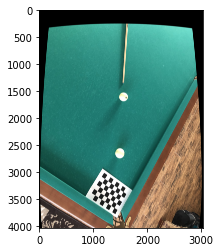

In [6]:
img = cv2.undistort(img, camera_mat, dist_coeffs, None, None)
undistort_gray_img = cv2.undistort(gray_img, camera_mat, dist_coeffs, None, None)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [7]:
retval, new_corners = cv2.findChessboardCorners(undistort_gray_img, pattern_size)
new_calibration_corners = cv2.cornerSubPix(undistort_gray_img, new_corners, win_size, zero_zone, criteria)
img = cv2.drawChessboardCorners(img, pattern_size, new_calibration_corners, retval)

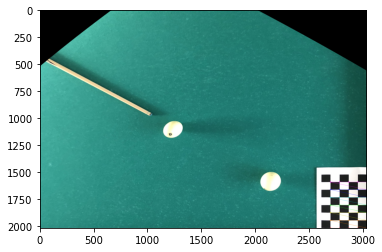

In [8]:
h, w, c = img.shape
object_points = np.float32([[h, w - norm(new_calibration_corners[0] - new_calibration_corners[4])], [h, w], [h - norm(new_calibration_corners[pattern_size[0] * pattern_size[1] - 1] - new_calibration_corners[4]), w  - norm(new_calibration_corners[0] - new_calibration_corners[4])], [h - norm(new_calibration_corners[pattern_size[0] * pattern_size[1] - 1] - new_calibration_corners[4]), w]])
img_points = np.float32([new_calibration_corners[0], new_calibration_corners[pattern_size[0] - 1], new_calibration_corners[(pattern_size[1] - 1) * pattern_size[0]], new_calibration_corners[(pattern_size[1] - 1) * pattern_size[0] + pattern_size[0] - 1]])

perspective_matrix = cv2.getPerspectiveTransform(object_points, img_points)
img = cv2.warpPerspective(img, perspective_matrix, (h, w), flags=cv2.WARP_INVERSE_MAP + cv2.INTER_LINEAR,
                               borderMode=cv2.BORDER_CONSTANT,
                               borderValue=(0, 0, 0))

img = cv2.flip(img, 1)
img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
h, w, c = img.shape
img = img[h//2:,:,:]
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 3. Trajectory

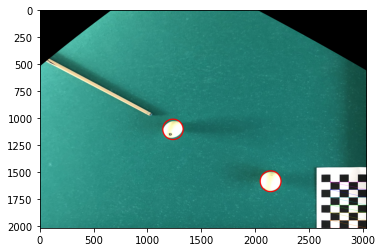

In [9]:
new_img = img
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, img_gray = cv2.threshold(img_gray, 175, 255, cv2.THRESH_BINARY)
edges = cv2.Canny(img_gray, 50, 100, 3);

contours, _ = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
centre = []
rad = 0
for c in contours:
    (y,x), radius = cv2.minEnclosingCircle(c)
    x = int(x)
    y = int(y)
    radius = int(radius)
    if 85 < radius < 100:
        rad = radius
        centre.append((y,x))
        new_img = cv2.circle(new_img, centre[-1], radius, (0, 0, 255), 10)

plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

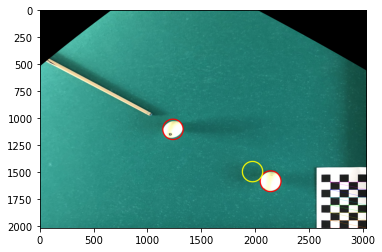

In [13]:
centre = sorted(centre, key=lambda x: x[1])
y0 = centre[0][0]
x0 = centre[0][1]
y1 = centre[1][0]
x1 = centre[1][1]

dy = y1 - y0
dx = x1 - x0

a = dx ** 2  + dy ** 2
b = 2 * (y0 * dy + x0 * dx - y1 * dy - x1 * dx)
c = x0 ** 2 + y0 ** 2  + x1 ** 2  + y1 ** 2 - 2 * x0 * x1 - 2 * y0 * y1 - rad ** 2
D = b ** 2 - 4 * a * c

k = ((-1) * b - D ** (0.5)) / (2 * a)

y_ = y0 + k * dy
x_ = x0 + k * dx

prev_y = int(y1 - 2 * (y1 - y_))
prev_x = int(x1 - 2 * (x1 - x_))

new_img = cv2.circle(new_img, (prev_y, prev_x), rad, (0, 255, 255), 10)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

True

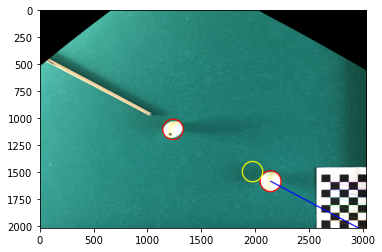

In [15]:
k = 20

next_y = y1 + k * dy
next_x = x1 + k * dx

new_img = cv2.line(new_img, (y1, x1), (next_y, next_x), (255, 0, 0), 10)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))
cv2.imwrite("data/result.png", new_img)